In [14]:
from io import BytesIO
from PIL import Image

def convert_to_jpeg(im):
    with BytesIO() as f:
        im.convert('RGB').save(f, format='JPEG')
        f.seek(0)
        img = Image.open(f)
        img.load()
        return img

In [15]:
from transformers import AutoImageProcessor, SwinForImageClassification
import numpy as np
import os
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.utils.class_weight import compute_class_weight


train_path = "./dataset"

image_processor = AutoImageProcessor.from_pretrained("microsoft/swin-large-patch4-window7-224")
model = SwinForImageClassification.from_pretrained("microsoft/swin-large-patch4-window7-224", num_labels=len(os.listdir(train_path)), ignore_mismatched_sizes=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

c:\Users\Stefano\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
Some weights of SwinForImageClassification were not initialized from the model checkpoint at microsoft/swin-large-patch4-window7-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 1536]) in the checkpoint and torch.Size([2, 1536]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to us

In [3]:
normalize_class_weights = True

In [4]:
import time
import torch
from torch.optim import Adam
from torch.utils.data import DataLoader
from torch.nn import CrossEntropyLoss
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from torch.cuda.amp import autocast, GradScaler  # For mixed precision training
from tqdm import tqdm
from torch.utils.data import Subset


# Define preprocessing transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
])

# Load the dataset from the 'train' folder
dataset = datasets.ImageFolder(train_path, transform=transform)

# Get class labels and their indices
class_names = dataset.classes

# Perform the stratified split into train and validation sets (80-20 split)
# We extract the indices of the dataset
indices = list(range(len(dataset)))

# Split the indices into train and validation (80-20 split, stratified by class)
train_indices, val_indices = train_test_split(
    indices, 
    test_size=0.2, 
    stratify=dataset.targets,  # Stratify by class
    random_state=42
)

# Create Subsets for train and validation sets
train_subset = Subset(dataset, train_indices)
val_subset = Subset(dataset, val_indices)

# DataLoaders with the subsets
train_loader = DataLoader(train_subset, batch_size=8, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_subset, batch_size=8, shuffle=False, num_workers=4, pin_memory=True)


# Compute class weights based on the training dataset
# Assuming train_loader has (image, label) tuples
all_labels = []
for _, labels in train_loader:
    all_labels.extend(labels.numpy())  # Collect all labels from the training set

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(all_labels), y=all_labels)
class_weights = torch.tensor(class_weights / class_weights.sum(), dtype=torch.float32).to(device) if normalize_class_weights else torch.tensor(class_weights, dtype=torch.float32).to(device)

# Optimizer and loss function
optimizer = Adam(model.parameters(), lr=3e-6)

# Loss function with normalized class weights (optional)
loss_fn = CrossEntropyLoss(weight=class_weights)

# Initialize the gradient scaler for mixed precision
scaler = GradScaler()

# Early stopping parameters
patience = 10  # Number of epochs with no improvement after which training will stop
best_val_loss = float('inf')  # Initialize to a large number
patience_counter = 0  # To count how many epochs have passed without improvement

# Training loop
num_epochs = 50

# Lists to store losses for plotting later
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    start_time = time.time()  # Record the start time for this epoch
    
    model.train()
    train_loss = 0
    
    # Create a tqdm progress bar for the training loop
    train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}", ncols=100, leave=False)

    for images, labels in train_loader_tqdm:
        images, labels = images.to(device), labels.to(device)

        # Mixed precision training
        optimizer.zero_grad()

        with autocast():  # Enables automatic mixed precision
            outputs = model(images).logits  # Get logits from the classification head
            loss = loss_fn(outputs, labels)

        # Backward pass and optimization
        scaler.scale(loss).backward()  # Scales the loss for precision
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Clip gradients
        scaler.step(optimizer)        # Optimizer step
        scaler.update()               # Updates the scaler
        
        train_loss += loss.item()

        # Update the progress bar with the current training loss
        train_loader_tqdm.set_postfix(train_loss=train_loss / (train_loader_tqdm.n + 1), refresh=True)

    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)  # Store training loss

    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {avg_train_loss}")

    # Validation loop
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images).logits
            outputs = torch.clamp(outputs, min=-1e7, max=1e7) # avoid extreme values
            loss = loss_fn(outputs, labels)
            val_loss += loss.item()

            # Calculate accuracy
            preds = torch.argmax(outputs, dim=1)  # Predictions
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)  # Store validation loss
    accuracy = correct / total
    print(f"Validation Loss: {avg_val_loss}, Accuracy: {accuracy * 100:.2f}%")
    
    # Check for early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0  # Reset counter as we have a new best model
        
        # Define the path to save the model weights
        model_save_path = "./chart_detection_model.pt"
        torch.save(model.state_dict(), model_save_path)
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping triggered after {epoch + 1} epochs")
            break  # Exit the training loop early
    
    # Calculate the elapsed time for this epoch
    end_time = time.time()  # Record the end time for this epoch
    epoch_duration = end_time - start_time  # Compute the duration
    print(f"Epoch {epoch + 1} completed in {epoch_duration:.2f} seconds\n")

Epoch 1/50, Train Loss: 0.14959834120564927
Validation Loss: 0.039028425478159164, Accuracy: 99.57%
Epoch 1 completed in 744.91 seconds



Epoch 2/50, Train Loss: 0.02932157519198882
Validation Loss: 0.02378197464340273, Accuracy: 99.74%
Epoch 2 completed in 740.01 seconds



Epoch 3/50, Train Loss: 0.019219071004759697
Validation Loss: 0.022549948535430242, Accuracy: 99.81%
Epoch 3 completed in 743.10 seconds



Epoch 4/50, Train Loss: 0.013122588436199083
Validation Loss: 0.020719016222377543, Accuracy: 99.82%
Epoch 4 completed in 739.34 seconds



Epoch 5/50, Train Loss: 0.008108336417665014
Validation Loss: 0.02174842450625217, Accuracy: 99.86%
Epoch 5 completed in 737.65 seconds



Epoch 6/50, Train Loss: 0.008971878598408933
Validation Loss: 0.02393639932389775, Accuracy: 99.79%
Epoch 6 completed in 739.54 seconds



Epoch 7/50, Train Loss: 0.006171203926024503
Validation Loss: 0.016864805708092134, Accuracy: 99.89%
Epoch 7 completed in 741.06 seconds



Epoch 8/50, Train Loss: 0.004651224291826673
Validation Loss: 0.02207658583575273, Accuracy: 99.82%
Epoch 8 completed in 743.97 seconds



Epoch 9/50, Train Loss: 0.004215227123602036
Validation Loss: 0.020539154857205498, Accuracy: 99.84%
Epoch 9 completed in 738.91 seconds



Epoch 10/50, Train Loss: 0.0019592803780445083
Validation Loss: 0.018167085563524157, Accuracy: 99.85%
Epoch 10 completed in 751.00 seconds



Epoch 11/50, Train Loss: 0.002067070809786691
Validation Loss: 0.01792909581525461, Accuracy: 99.86%
Epoch 11 completed in 741.25 seconds



Epoch 12/50, Train Loss: 0.003956075088694463
Validation Loss: 0.01823812977417737, Accuracy: 99.86%
Epoch 12 completed in 737.30 seconds



KeyboardInterrupt: 

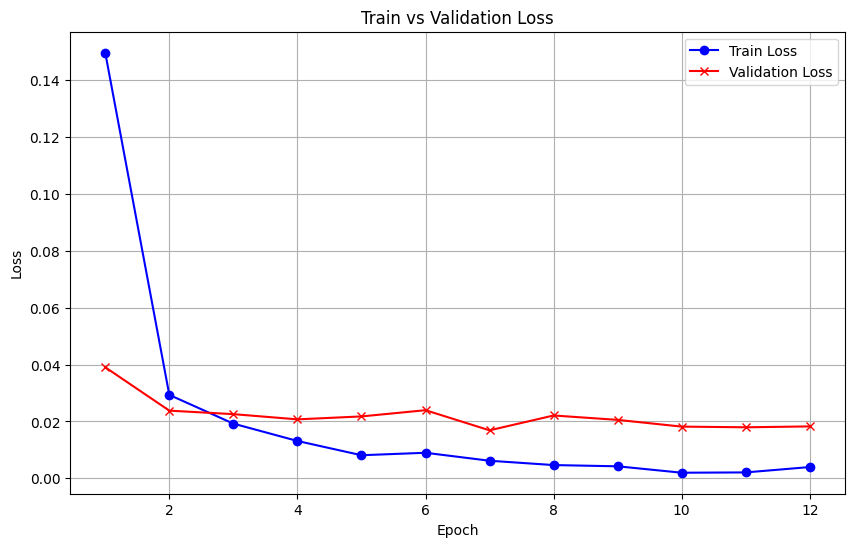

In [8]:
import matplotlib.pyplot as plt

# Plotting Train vs Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, epoch + 1), train_losses, label='Train Loss', color='blue', linestyle='-', marker='o')
plt.plot(range(1, epoch + 1), val_losses, label='Validation Loss', color='red', linestyle='-', marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [11]:
from tqdm import tqdm

validation_labels, validation_predictions = [], []

# Wrap the validation loop with tqdm for a progress bar
with torch.no_grad():
    val_loader_tqdm = tqdm(val_loader, desc="Validation Progress", ncols=100, leave=False)

    for images, labels in val_loader_tqdm:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images).logits

        # Calculate accuracy
        preds = torch.argmax(outputs, dim=1)  # Predictions

        # Update accuracy tracking
        validation_labels.extend(labels.cpu().numpy())  # True labels
        validation_predictions.extend(preds.cpu().numpy())  # Predicted labels

        # Optionally, you can display current metrics in tqdm
        val_loader_tqdm.set_postfix(batch_size=images.size(0), refresh=True)


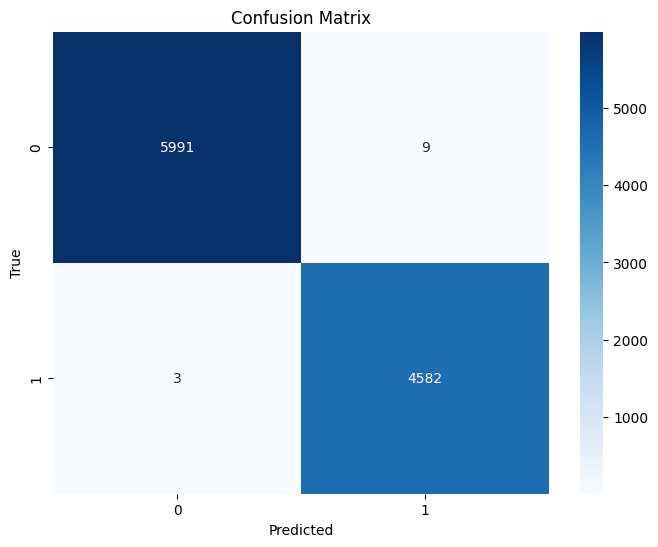

Accuracy: 99.89%
Precision (Weighted): 1.00
Recall (Weighted): 1.00
F1-Score (Weighted): 1.00


In [12]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# After training is done, calculate performance metrics on the entire validation set
# Confusion Matrix
cm = confusion_matrix(validation_labels, validation_predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(validation_labels), yticklabels=np.unique(validation_labels))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Calculate Accuracy, Precision, Recall, F1-Score
accuracy = accuracy_score(validation_labels, validation_predictions)
precision = precision_score(validation_labels, validation_predictions, average='weighted' if len(class_weights) > 2 else 'binary')  # Weighted for multi-class
recall = recall_score(validation_labels, validation_predictions, average='weighted' if len(class_weights) > 2 else 'binary')
f1 = f1_score(validation_labels, validation_predictions, average='weighted' if len(class_weights) > 2 else 'binary')

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision (Weighted): {precision:.2f}")
print(f"Recall (Weighted): {recall:.2f}")
print(f"F1-Score (Weighted): {f1:.2f}")

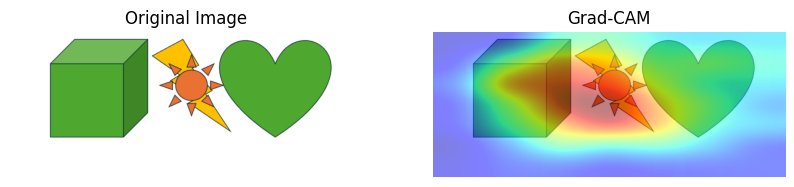

In [19]:
import torch
import torch.nn.functional as F
from torchvision import models, transforms
from torchvision.transforms.functional import normalize, resize, to_pil_image
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image


class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model.eval()  # Ensure the model is in evaluation mode
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        # Hook to capture gradients
        self.hook_layers()

    def hook_layers(self):
        def forward_hook(module, input, output):
            self.activations = output  # Save feature maps (activations)

        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0]  # Save gradients from the backward pass

        for name, module in self.model.named_modules():
            if name == self.target_layer:
                module.register_forward_hook(forward_hook)
                module.register_backward_hook(backward_hook)

    def generate_heatmap(self, input_tensor, class_index):
        # Perform a forward pass and get the logits
        logits = self.model(input_tensor)
        logits[:, class_index].backward()  # Backpropagate the class index gradient

        # Global average pooling over the gradients
        pooled_grads = torch.mean(self.gradients, dim=[0, 2, 3])

        # Weight the activations by the pooled gradients
        for i in range(pooled_grads.shape[0]):
            self.activations[:, i, :, :] *= pooled_grads[i]

        # Compute the heatmap by averaging over channels and normalize it
        heatmap = torch.mean(self.activations, dim=1).squeeze().cpu().detach().numpy()
        heatmap = np.maximum(heatmap, 0)  # ReLU to keep positive values
        heatmap /= heatmap.max()  # Normalize to [0, 1]
        return heatmap

    def overlay_heatmap(self, heatmap, image):
        heatmap = np.uint8(255 * heatmap)  # Scale heatmap to [0, 255]
        heatmap = Image.fromarray(heatmap).resize(image.size, resample=Image.BICUBIC)
        heatmap = np.array(heatmap)
        heatmap = plt.cm.jet(heatmap / 255.0)[:, :, :3]  # Apply colormap
        overlay = (0.5 * heatmap + 0.5 * np.array(image) / 255.0) * 255
        return overlay.astype(np.uint8)

# Load your pretrained model and dataset
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet50(pretrained=True).to(device)

# Specify the target layer for Grad-CAM
target_layer = "layer4"  # Layer name in ResNet50

# Initialize Grad-CAM
gradcam = GradCAM(model=model, target_layer=target_layer)

# Preprocessing transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load an image and preprocess it
image = Image.open(image_path).convert("RGB")
input_tensor = transform(image).unsqueeze(0).to(device)

# Perform Grad-CAM
class_index = torch.argmax(model(input_tensor)).item()  # Predicted class
heatmap = gradcam.generate_heatmap(input_tensor, class_index)

# Overlay the heatmap on the original image
overlay = gradcam.overlay_heatmap(heatmap, image)

# Display the result
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(image)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Grad-CAM")
plt.imshow(overlay)
plt.axis("off")
plt.show()
